In [1]:
import os
import json
import time
from typing import Dict, List, Tuple, Optional

import nltk
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from tqdm.notebook import tqdm

class Config:
    def __init__(self):
        self.vqa_dir = ""
        self.img_dir_train = "scene_img_abstract_v002_train2017"
        self.img_dir_val = "scene_img_abstract_v002_val2017"
        
        # Data files
        self.train_questions_file = os.path.join(self.vqa_dir, "OpenEnded_abstract_v002_train2017_questions.json")
        self.train_annotations_file = os.path.join(self.vqa_dir, "abstract_v002_train2017_annotations.json")
        self.val_questions_file = os.path.join(self.vqa_dir, "OpenEnded_abstract_v002_val2017_questions.json")
        self.val_annotations_file = os.path.join(self.vqa_dir, "abstract_v002_val2017_annotations.json")
        
        # Model parameters
        self.embed_dim = 300
        self.hidden_dim = 512
        self.num_layers = 1
        self.dropout = 0.5
        
        # Training parameters
        self.batch_size = 32
        self.num_epochs = 10
        self.learning_rate = 1e-4
        self.checkpoint_frequency = 5
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_json_file(filepath: str) -> dict:
    with open(filepath, 'r') as f:
        return json.load(f)

def build_vocab(questions: List[dict]) -> Dict[str, int]:
    vocab = {'<pad>': 0, '<unk>': 1}
    idx = 2
    words = set()
    
    for q in questions:
        words.update(nltk.word_tokenize(q['question'].lower()))
    
    for word in sorted(words):
        vocab[word] = idx
        idx += 1
    
    return vocab

class VQADataset(Dataset):
    def __init__(self, img_dir: str, questions: List[dict], 
                 annotations: List[dict], vocab: Dict[str, int], 
                 transform: Optional[transforms.Compose] = None):
        self.img_dir = img_dir
        self.transform = transform
        self.vocab = vocab
        self.data = self._prepare_data(questions, annotations)

    def _prepare_data(self, questions: List[dict], annotations: List[dict]) -> List[Tuple]:
        return [
            (q['image_id'], q['question'], a['multiple_choice_answer'])
            for q, a in zip(questions, annotations)
            if a['multiple_choice_answer'] in ['yes', 'no']
        ]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        img_id, question, answer = self.data[idx]
        
        # Handle image loading
        img = self._load_image(img_id)
        if self.transform:
            img = self.transform(img)
            
        # Process question
        question_vec = self._tokenize_question(question)
        
        # Convert answer to label
        label = torch.tensor(1 if answer == 'yes' else 0, dtype=torch.long)
        
        return img, question_vec, label

    def _load_image(self, img_id: str) -> Image.Image:
        dataset_type = 'train' if 'train' in self.img_dir else 'val'
        img_filename = f"abstract_v002_{dataset_type}2015_{int(img_id):012d}.png"
        img_path = os.path.join(self.img_dir, img_filename)
        
        try:
            return Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            return Image.new('RGB', (224, 224), (0, 0, 0))

    def _tokenize_question(self, question: str) -> torch.Tensor:
        tokens = nltk.word_tokenize(question.lower())
        return torch.tensor([self.vocab.get(word, self.vocab['<unk>']) for word in tokens], 
                          dtype=torch.long)

class VQAModel(nn.Module):
    def __init__(self, vocab_size: int, config: Config):
        super().__init__()
        self.cnn = self._setup_cnn()
        self.question_encoder = self._setup_question_encoder(vocab_size, config)
        self.classifier = self._setup_classifier()

    def _setup_cnn(self) -> nn.Module:
        cnn = models.vgg16(pretrained=True)
        cnn.classifier = nn.Sequential()
        for param in cnn.parameters():
            param.requires_grad = False
        return cnn

    def _setup_question_encoder(self, vocab_size: int, config: Config) -> nn.ModuleDict:
        return nn.ModuleDict({
            'embed': nn.Embedding(vocab_size, config.embed_dim, padding_idx=0),
            'lstm': nn.LSTM(config.embed_dim, config.hidden_dim, 
                          config.num_layers, batch_first=True)
        })

    def _setup_classifier(self) -> nn.Sequential:
        return nn.Sequential(
            nn.Linear(25088 + 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2)
        )

    def forward(self, img: torch.Tensor, question: torch.Tensor, 
                lengths: List[int]) -> torch.Tensor:
        img_features = self.cnn(img).view(img.size(0), -1)
        question_features = self._encode_question(question, lengths)
        combined = torch.cat([img_features, question_features], dim=1)
        return self.classifier(combined)

    def _encode_question(self, question: torch.Tensor, 
                        lengths: List[int]) -> torch.Tensor:
        embedded = self.question_encoder['embed'](question)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.question_encoder['lstm'](packed)
        return hidden[-1]

class Trainer:
    def __init__(self, model: nn.Module, train_loader: DataLoader, 
                 val_loader: DataLoader, config: Config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        self.best_val_accuracy = 0.0

    def train(self):
        start_time = time.time()
        
        for epoch in tqdm(range(self.config.num_epochs)):
            train_loss = self._train_epoch()
            val_accuracy = self._validate_epoch()
            
            self._save_checkpoints(epoch, val_accuracy)
            self._print_epoch_stats(epoch, train_loss, val_accuracy)

        print(f"Training completed in {time.time() - start_time:.2f} seconds.")

    def _train_epoch(self) -> float:
        self.model.train()
        total_loss = 0
        
        for imgs, questions, labels, lengths in tqdm(self.train_loader):
            loss = self._train_step(imgs, questions, labels, lengths)
            total_loss += loss
            
        return total_loss / len(self.train_loader)

    def _train_step(self, imgs: torch.Tensor, questions: torch.Tensor, 
                   labels: torch.Tensor, lengths: List[int]) -> float:
        imgs = imgs.to(self.config.device)
        questions = questions.to(self.config.device)
        labels = labels.to(self.config.device)
        
        self.optimizer.zero_grad()
        outputs = self.model(imgs, questions, lengths)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    def _validate_epoch(self) -> float:
        self.model.eval()
        correct = total = 0
        
        with torch.no_grad():
            for imgs, questions, labels, lengths in tqdm(self.val_loader):
                correct_batch, total_batch = self._validate_step(
                    imgs, questions, labels, lengths)
                correct += correct_batch
                total += total_batch
                
        return correct / total

    def _validate_step(self, imgs: torch.Tensor, questions: torch.Tensor,
                      labels: torch.Tensor, lengths: List[int]) -> Tuple[int, int]:
        imgs = imgs.to(self.config.device)
        questions = questions.to(self.config.device)
        labels = labels.to(self.config.device)
        
        outputs = self.model(imgs, questions, lengths)
        predictions = torch.argmax(outputs, dim=1)
        
        return (predictions == labels).sum().item(), labels.size(0)

    def _save_checkpoints(self, epoch: int, val_accuracy: float):
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self._save_model(epoch, val_accuracy, is_best=True)
        
        if (epoch + 1) % self.config.checkpoint_frequency == 0:
            self._save_model(epoch, val_accuracy, is_best=False)

    def _save_model(self, epoch: int, val_accuracy: float, is_best: bool):
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_accuracy': val_accuracy
        }
        
        path = 'best_vqa_model.pth' if is_best else \
               f'checkpoint_epoch_{epoch+1}.pth'
        torch.save(checkpoint, path)
        
        status = "Best" if is_best else "Checkpoint"
        print(f"**Saved {status} Model at Epoch {epoch+1} "
              f"with Validation Accuracy: {val_accuracy:.4f}**\n")

    def _print_epoch_stats(self, epoch: int, train_loss: float, 
                          val_accuracy: float):
        print(f"Epoch [{epoch+1}/{self.config.num_epochs}]")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}\n")

def main():
    config = Config()
    
    train_questions = load_json_file(config.train_questions_file)['questions']
    train_annotations = load_json_file(config.train_annotations_file)['annotations']
    val_questions = load_json_file(config.val_questions_file)['questions']
    val_annotations = load_json_file(config.val_annotations_file)['annotations']
    
    vocab = build_vocab(train_questions)
    print(f"Vocabulary size: {len(vocab)}")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    train_dataset = VQADataset(
        config.img_dir_train,
        train_questions,
        train_annotations,
        vocab,
        transform
    )
    
    val_dataset = VQADataset(
        config.img_dir_val,
        val_questions,
        val_annotations,
        vocab,
        transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=lambda batch: (
            torch.stack([x[0] for x in batch]),
            pad_sequence([x[1] for x in batch], batch_first=True, padding_value=0),
            torch.stack([x[2] for x in batch]),
            [len(x[1]) for x in batch]
        )
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=lambda batch: (
            torch.stack([x[0] for x in batch]),
            pad_sequence([x[1] for x in batch], batch_first=True, padding_value=0),
            torch.stack([x[2] for x in batch]),
            [len(x[1]) for x in batch]
        )
    )
    
    model = VQAModel(vocab_size=len(vocab), config=config).to(config.device)
    trainer = Trainer(model, train_loader, val_loader, config)
    
    trainer.train()

if __name__ == "__main__":
    nltk.download('punkt')
    main()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary size: 2752


C:\Users\DV\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DV\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Best Model at Epoch 1 with Validation Accuracy: 0.5081**

Epoch [1/10]
Training Loss: 0.7054
Validation Accuracy: 0.5081



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Best Model at Epoch 2 with Validation Accuracy: 0.5105**

Epoch [2/10]
Training Loss: 0.6962
Validation Accuracy: 0.5105



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/10]
Training Loss: 0.6951
Validation Accuracy: 0.5087



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/10]
Training Loss: 0.6945
Validation Accuracy: 0.5102



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Checkpoint Model at Epoch 5 with Validation Accuracy: 0.5102**

Epoch [5/10]
Training Loss: 0.6939
Validation Accuracy: 0.5102



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Best Model at Epoch 6 with Validation Accuracy: 0.5191**

Epoch [6/10]
Training Loss: 0.6939
Validation Accuracy: 0.5191



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/10]
Training Loss: 0.6922
Validation Accuracy: 0.5140



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Best Model at Epoch 8 with Validation Accuracy: 0.5196**

Epoch [8/10]
Training Loss: 0.6912
Validation Accuracy: 0.5196



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Best Model at Epoch 9 with Validation Accuracy: 0.5211**

Epoch [9/10]
Training Loss: 0.6907
Validation Accuracy: 0.5211



  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

**Saved Checkpoint Model at Epoch 10 with Validation Accuracy: 0.5134**

Epoch [10/10]
Training Loss: 0.6874
Validation Accuracy: 0.5134

Training completed in 2832.41 seconds.


Loading checkpoint...
Rebuilding vocabulary from training data...
Rebuilt vocabulary with size: 2752
Creating model...


C:\Users\DV\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DV\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading validation data...
Analyzing predictions...
Displaying results...


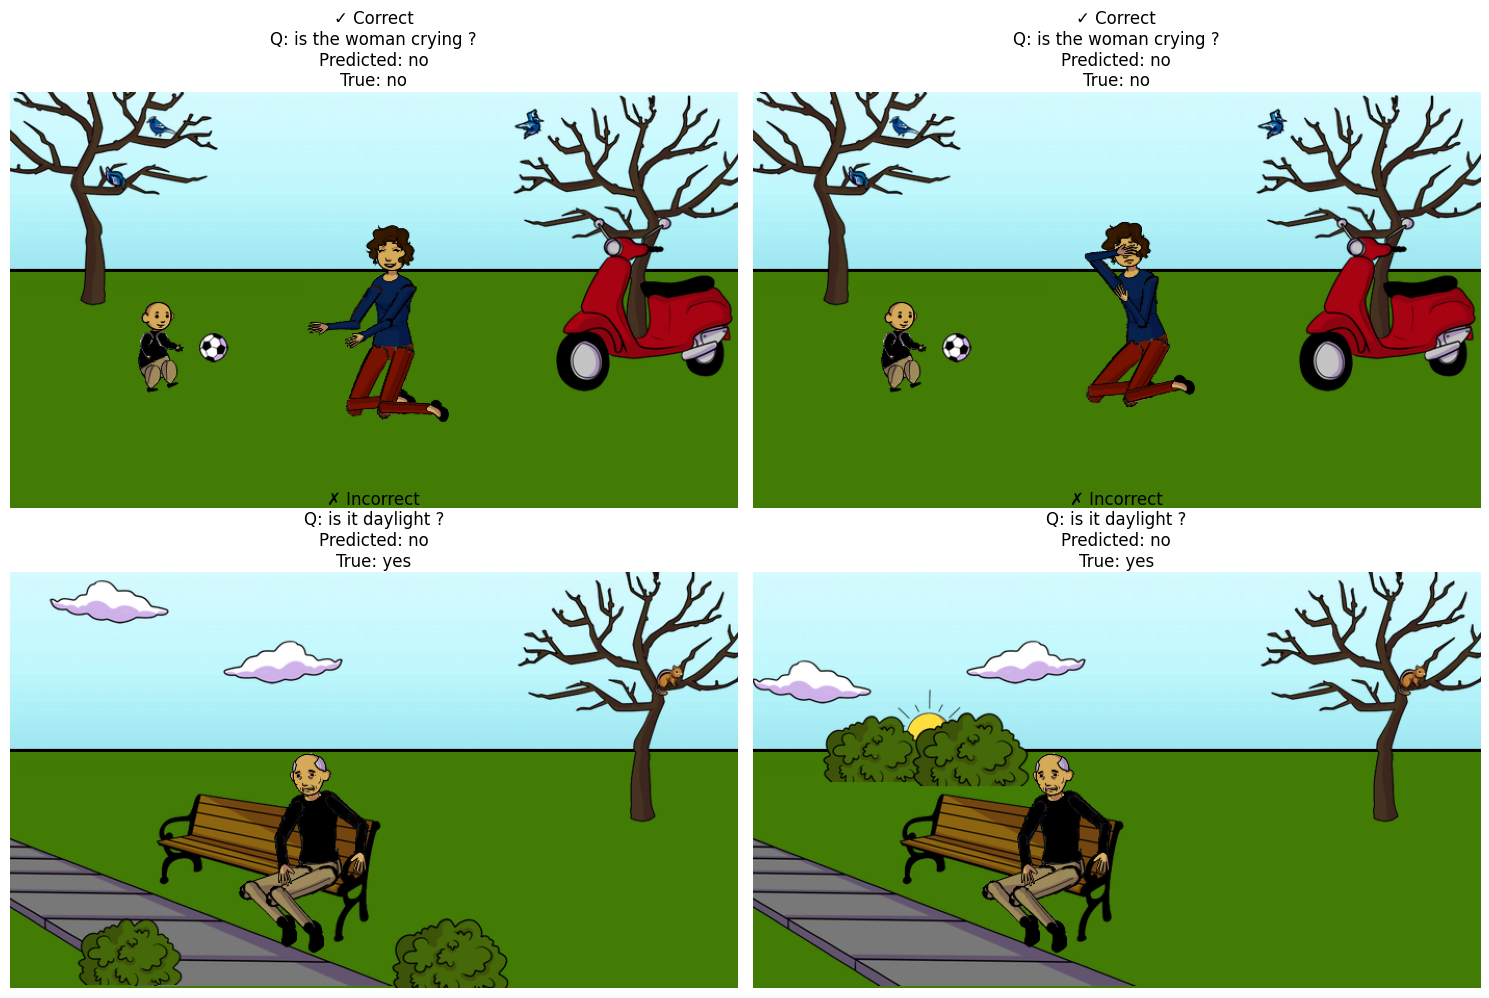


Detailed Analysis:

Example 1 (Correct):
Question: is the woman crying ?
Predicted Answer: no
True Answer: no
--------------------------------------------------

Example 2 (Correct):
Question: is the woman crying ?
Predicted Answer: no
True Answer: no
--------------------------------------------------

Example 3 (Incorrect):
Question: is it daylight ?
Predicted Answer: no
True Answer: yes
--------------------------------------------------

Example 4 (Incorrect):
Question: is it daylight ?
Predicted Answer: no
True Answer: yes
--------------------------------------------------


In [9]:
def rebuild_training_vocab(config: Config) -> Dict[str, int]:

    print("Rebuilding vocabulary from training data...")
    train_questions = load_json_file(config.train_questions_file)['questions']
    vocab = {'<pad>': 0, '<unk>': 1}
    idx = 2
    words = set()
    
    for q in train_questions:
        words.update(nltk.word_tokenize(q['question'].lower()))
    
    for word in sorted(words):
        vocab[word] = idx
        idx += 1
    
    print(f"Rebuilt vocabulary with size: {len(vocab)}")
    return vocab

def display_predictions(model_path: str, config: Config, device: torch.device):
    
    print("Loading checkpoint...")
    checkpoint = torch.load(model_path)
    
    # Rebuild vocabulary from training data
    vocab = rebuild_training_vocab(config)
    
    print("Creating model...")
    model = VQAModel(vocab_size=len(vocab), config=config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print("Loading validation data...")
    val_questions = load_json_file(config.val_questions_file)['questions']
    val_annotations = load_json_file(config.val_annotations_file)['annotations']
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    val_dataset = VQADataset(
        config.img_dir_val,
        val_questions,
        val_annotations,
        vocab,
        transform
    )
    
    rev_vocab = {idx: word for word, idx in vocab.items()}

    correct_examples = []
    incorrect_examples = []

    print("Analyzing predictions...")
    with torch.no_grad():
        for idx in range(len(val_dataset)):
            img, question, label = val_dataset[idx]
            
            img = img.unsqueeze(0).to(device)
            question = question.unsqueeze(0).to(device)
            lengths = [len(question[0])]
            
            output = model(img, question, lengths)
            pred = torch.argmax(output, dim=1).item()
            
            example = {
                'image_id': val_dataset.data[idx][0],
                'question': ' '.join([rev_vocab[q.item()] for q in question[0] if q.item() != 0]),
                'prediction': 'yes' if pred == 1 else 'no',
                'true_label': 'yes' if label.item() == 1 else 'no',
                'image': val_dataset._load_image(val_dataset.data[idx][0])
            }
            
            if pred == label.item() and len(correct_examples) < 2:
                correct_examples.append(example)
            elif pred != label.item() and len(incorrect_examples) < 2:
                incorrect_examples.append(example)
                
            if len(correct_examples) == 2 and len(incorrect_examples) == 2:
                break
    
    # Display results made with help from GPT
    print("Displaying results...")
    plt.figure(figsize=(15, 10))
    
    for i, example in enumerate(correct_examples + incorrect_examples):
        plt.subplot(2, 2, i + 1)
        plt.imshow(example['image'])
        plt.axis('off')
        
        status = "✓ Correct" if example in correct_examples else "✗ Incorrect"
        title = (f"{status}\n"
                f"Q: {example['question']}\n"
                f"Predicted: {example['prediction']}\n"
                f"True: {example['true_label']}")
        
        plt.title(title, wrap=True)
    
    plt.tight_layout()
    plt.show()

    print("\nDetailed Analysis:")
    print("=" * 50)
    
    for i, example in enumerate(correct_examples + incorrect_examples):
        status = "Correct" if example in correct_examples else "Incorrect"
        print(f"\nExample {i+1} ({status}):")
        print(f"Question: {example['question']}")
        print(f"Predicted Answer: {example['prediction']}")
        print(f"True Answer: {example['true_label']}")
        print("-" * 50)

# Usage example:
if __name__ == "__main__":
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    display_predictions('best_vqa_model.pth', config, device)

Rebuilding vocabulary from training data...
Rebuilt vocabulary with size: 2752


C:\Users\DV\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DV\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/11326 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


Example 1 (✗ Incorrect):
Question: is it daylight ?
Predicted: no
True: yes
--------------------------------------------------

Example 2 (✗ Incorrect):
Question: is it daylight ?
Predicted: no
True: yes
--------------------------------------------------

Example 3 (✓ Correct):
Question: is the woman crying ?
Predicted: no
True: no
--------------------------------------------------

Example 4 (✓ Correct):
Question: is the woman crying ?
Predicted: no
True: no
--------------------------------------------------


C:\Users\DV\AppData\Local\Temp\ipykernel_20956\2656156317.py:249: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  example['figure'].show()


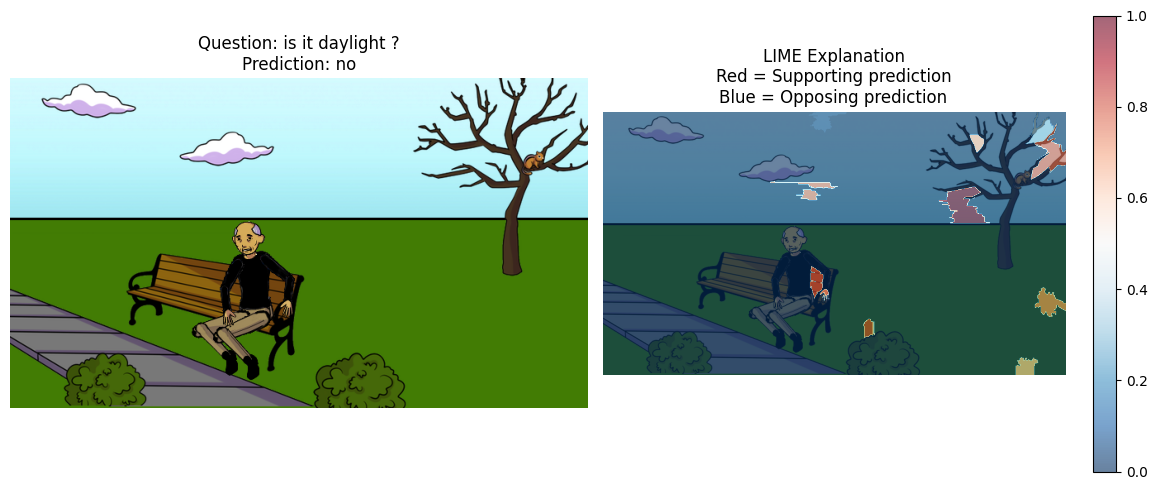

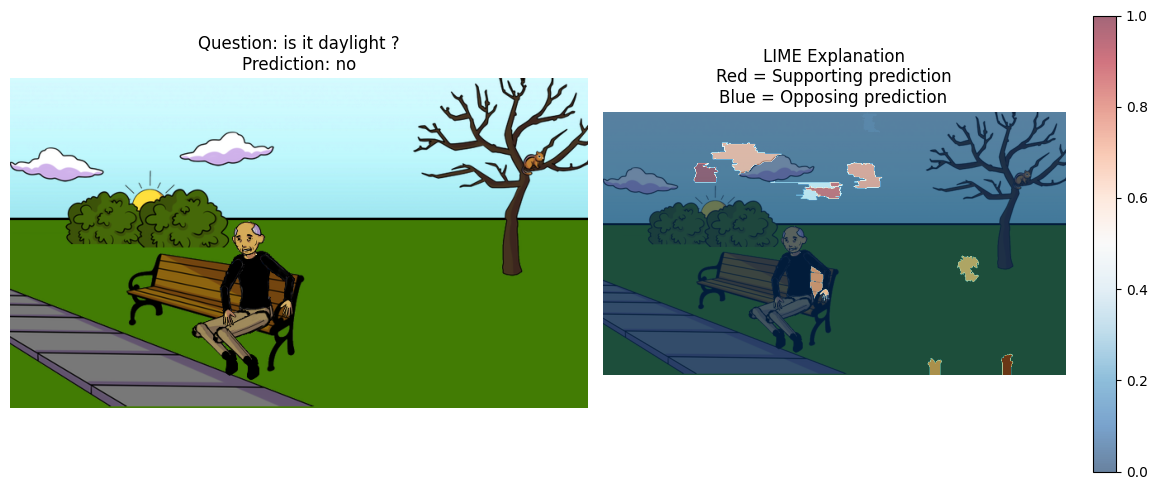

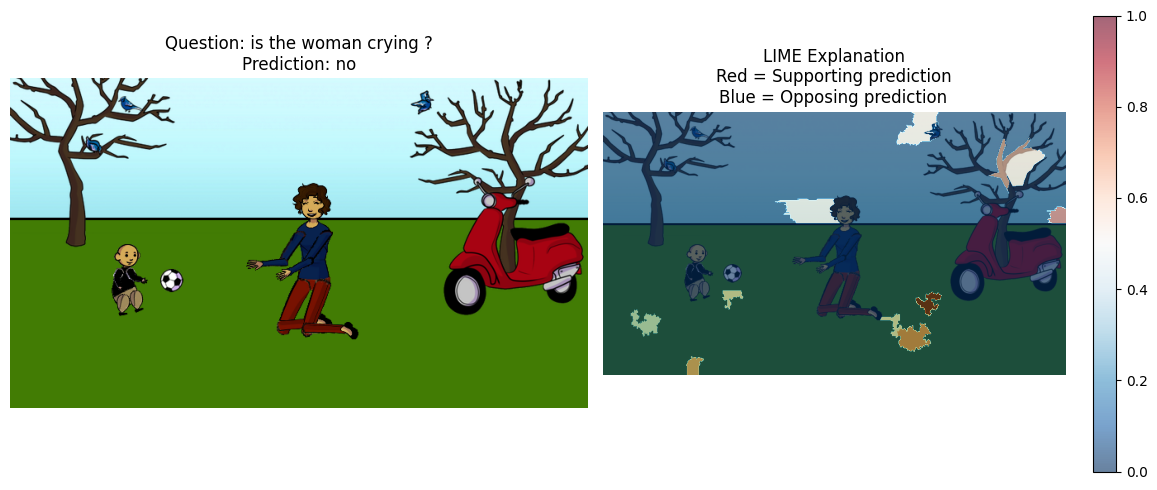

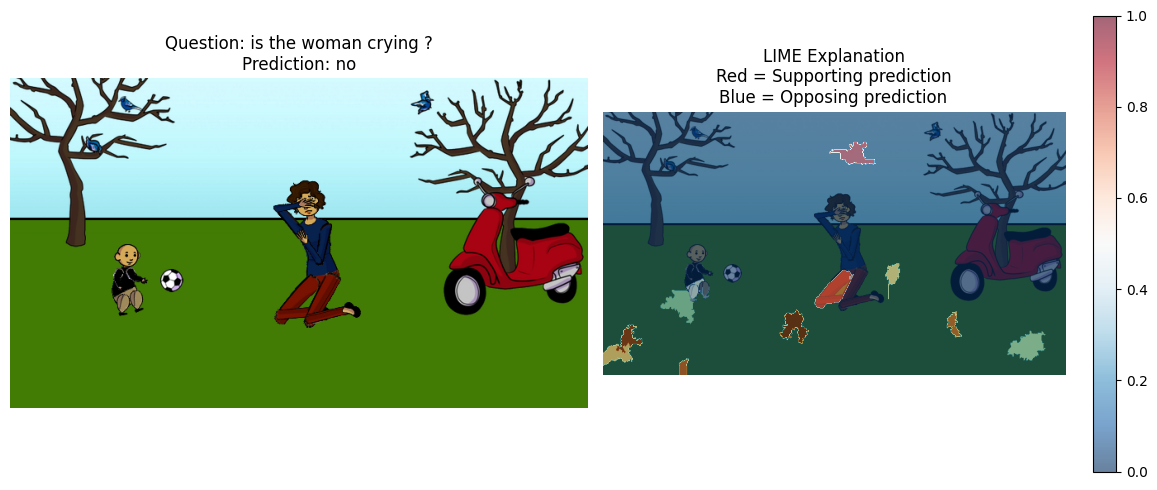

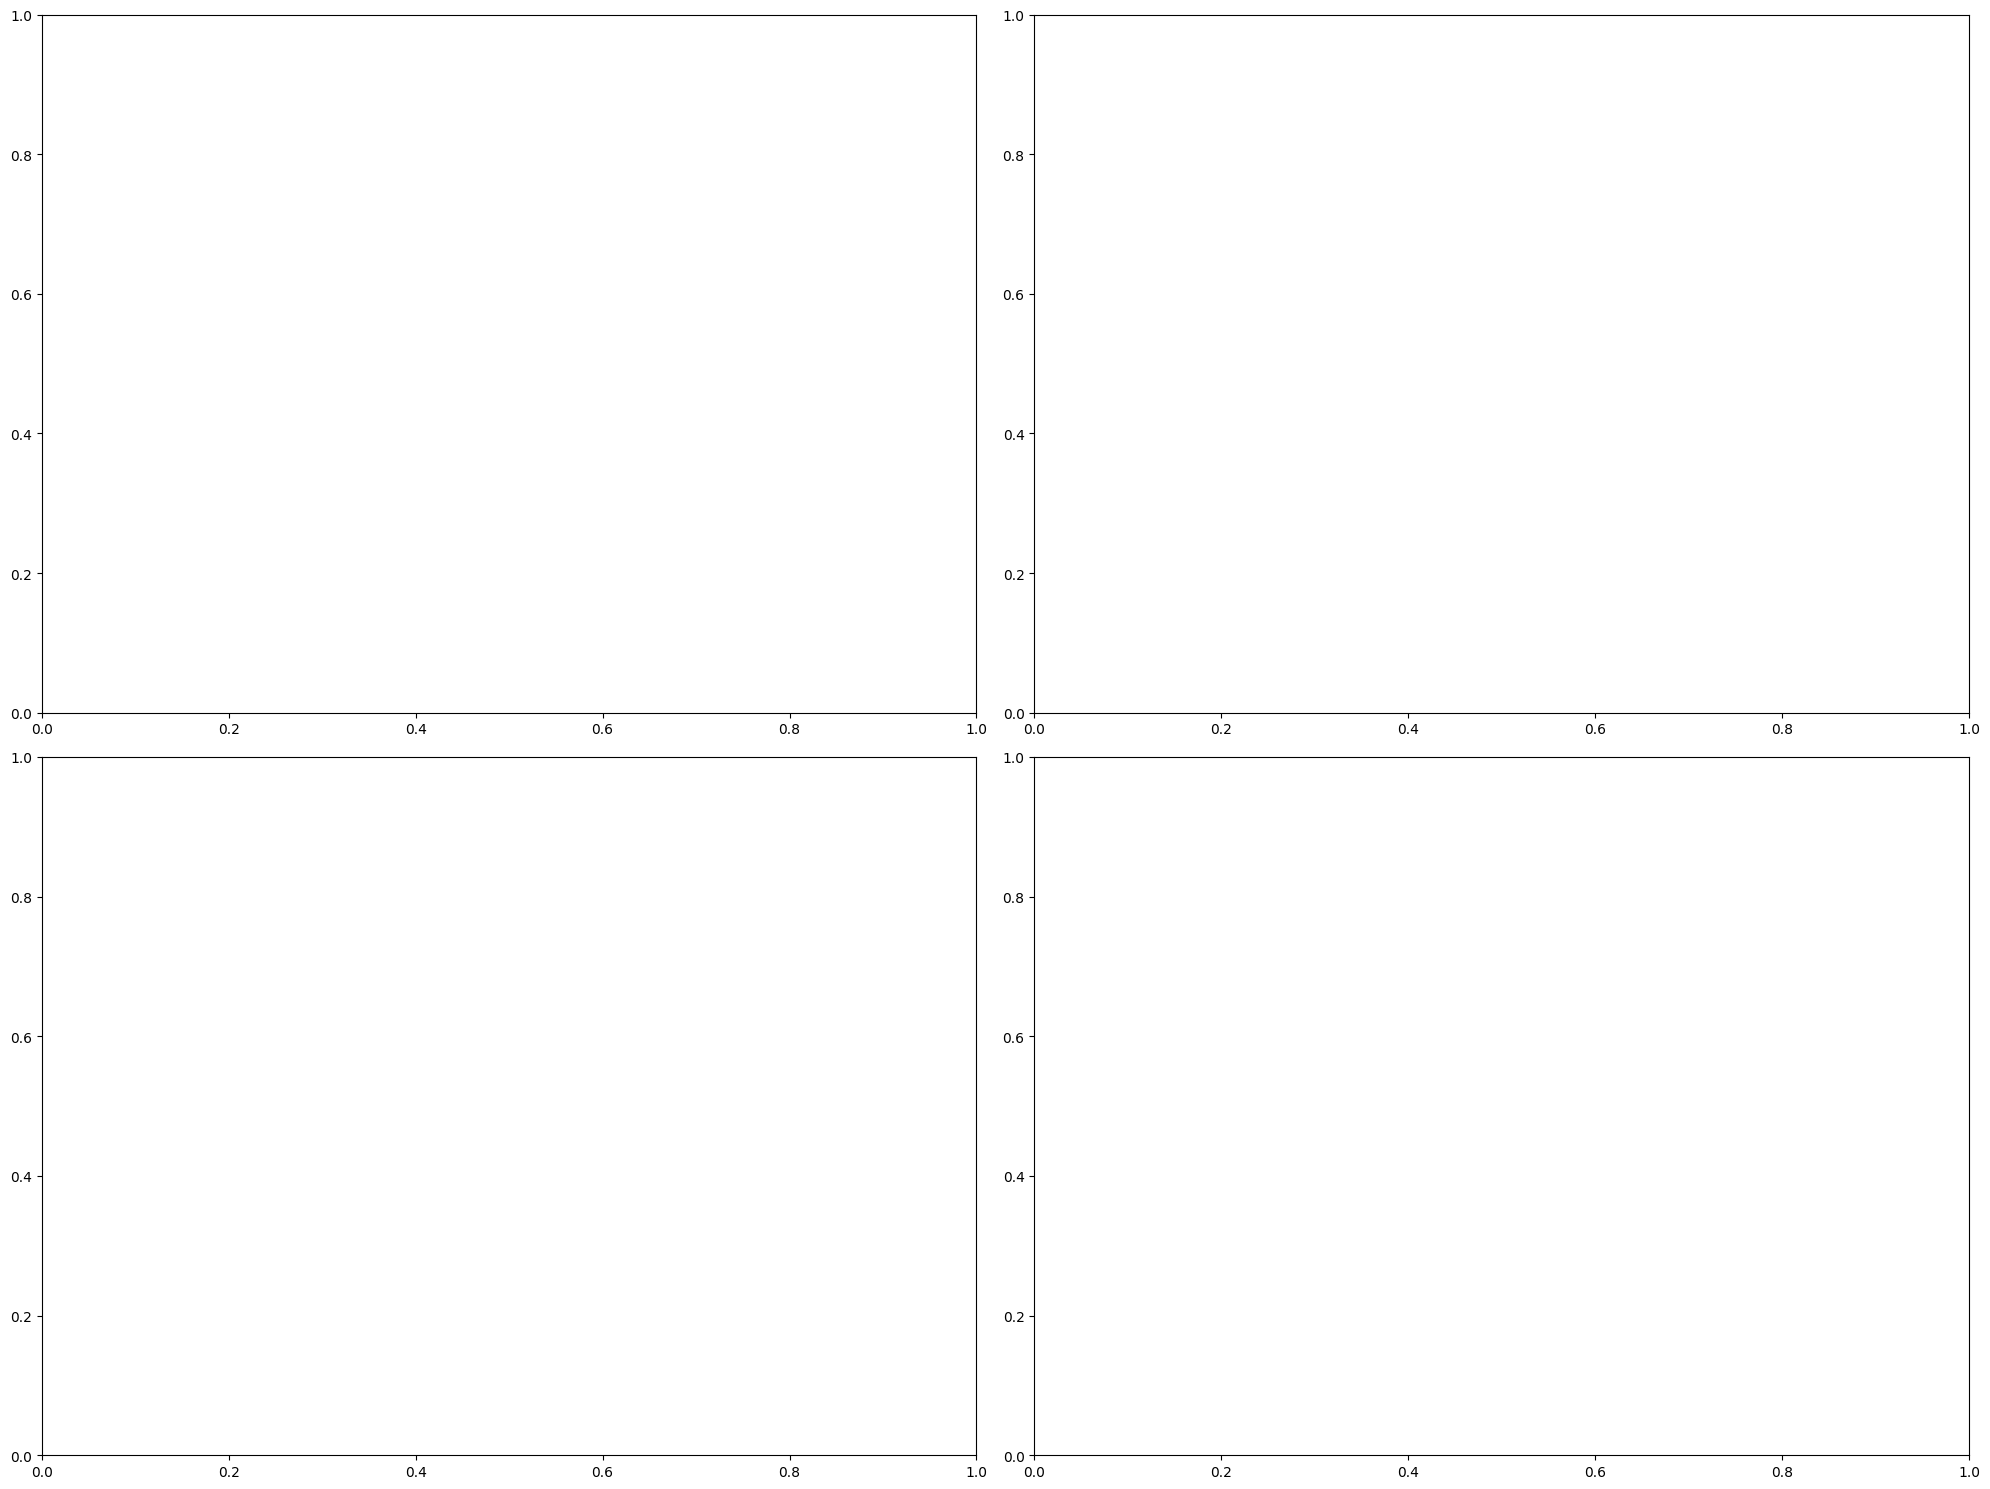

In [8]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, lars_path
from skimage.segmentation import quickshift
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any

class VQALimeExplainer:

    def __init__(self, kernel_width=0.25):
        self.kernel_width = kernel_width

    def _generate_lars_path(self, weighted_data, weighted_labels):
        alphas, _, coef_path = lars_path(weighted_data, weighted_labels, method='lasso')
        feature_sets = []
        scores = []

        for coef in coef_path.T:
            nonzero_features = np.nonzero(coef)[0]
            feature_sets.append(nonzero_features)
            
            if len(nonzero_features) > 0:
                ridge = Ridge(alpha=0.01)
                ridge.fit(weighted_data[:, nonzero_features], weighted_labels)
                scores.append(ridge.score(weighted_data[:, nonzero_features], weighted_labels))
            else:
                scores.append(float('-inf'))

            if len(nonzero_features) >= 10:
                break

        return feature_sets, scores

    def _fit_lasso(self, data, labels, weights, num_features):
        weighted_data = data * np.sqrt(weights)[:, np.newaxis]
        weighted_labels = labels * np.sqrt(weights)

        feature_sets, scores = self._generate_lars_path(weighted_data, weighted_labels)
        
        best_score = float('-inf')
        best_features = None
        
        for features, score in zip(feature_sets, scores):
            if len(features) <= num_features and score > best_score:
                best_score = score
                best_features = features

        ridge = Ridge(alpha=0.01, fit_intercept=True)
        ridge.fit(weighted_data[:, best_features], weighted_labels)
        
        coef = np.zeros(data.shape[1])
        coef[best_features] = ridge.coef_

        return coef

    def explain_instance(self, image: np.ndarray, question: torch.Tensor, 
                        model: torch.nn.Module, vocab: Dict[str, int], 
                        device: torch.device, num_samples: int = 100, 
                        num_features: int = 10, batch_size: int = 10) -> Dict[str, Any]:

        segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)
        num_segments = np.unique(segments).shape[0]

        random_state = check_random_state(None)
        perturbations = random_state.randint(0, 2, num_samples * num_segments)\
                       .reshape((num_samples, num_segments))

        perturbed_images = []
        for pert in perturbations:
            perturbed = image.copy()
            for segment_id in range(num_segments):
                if pert[segment_id] == 0:
                    perturbed[segments == segment_id] = (
                        np.mean(image[segments == segment_id], axis=0))
            perturbed_images.append(perturbed)

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        predictions = []
        model.eval()
        with torch.no_grad():
            for i in tqdm(range(0, len(perturbed_images), batch_size)):
                batch_images = []
                for img in perturbed_images[i:i+batch_size]:
                    pil_img = Image.fromarray(img.astype('uint8'))
                    tensor_img = transform(pil_img).to(device)
                    batch_images.append(tensor_img)
                
                batch_tensor = torch.stack(batch_images)
                question_batch = question.repeat(len(batch_images), 1)
                lengths = [len(question[0])] * len(batch_images)
                
                outputs = model(batch_tensor, question_batch, lengths)
                probs = torch.softmax(outputs, dim=1)
                predictions.extend(probs[:, 1].cpu().numpy())

        predictions = np.array(predictions)

        distances = pairwise_distances(
            perturbations,
            perturbations[0].reshape(1, -1),
            metric='cosine'
        ).ravel()
        weights = np.sqrt(np.exp(-(distances ** 2) / self.kernel_width ** 2))

        feature_weights = self._fit_lasso(perturbations, predictions, weights, num_features)

        return {
            'segments': segments,
            'feature_weights': feature_weights,
            'predicted_value': predictions[0]
        }

# Visualization mask written with help from GPT since I am really bad at remembering matplotlib things
def visualize_lime_explanation(image: np.ndarray, explanation: Dict[str, Any], 
                             question: str, prediction: str) -> plt.Figure:
    segments = explanation['segments']
    feature_weights = explanation['feature_weights']
    
    mask = np.zeros(segments.shape, dtype=bool)
    for segment_id, weight in enumerate(feature_weights):
        if weight != 0:
            mask[segments == segment_id] = True

    heatmap = np.zeros(segments.shape[:2])
    for segment_id, weight in enumerate(feature_weights):
        heatmap[segments == segment_id] = weight

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(image)
    ax1.set_title(f'Question: {question}\nPrediction: {prediction}')
    ax1.axis('off')
    
    ax2.imshow(image)
    heatmap_overlay = ax2.imshow(heatmap, cmap='RdBu_r', alpha=0.6)
    ax2.set_title('LIME Explanation\nRed = Supporting prediction\nBlue = Opposing prediction')
    ax2.axis('off')
    plt.colorbar(heatmap_overlay, ax=ax2)
    
    plt.tight_layout()
    return fig

def explain_vqa_predictions(model_path: str, config: Config, device: torch.device):
    checkpoint = torch.load(model_path)
    vocab = rebuild_training_vocab(config)
    
    model = VQAModel(vocab_size=len(vocab), config=config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    val_questions = load_json_file(config.val_questions_file)['questions']
    val_annotations = load_json_file(config.val_annotations_file)['annotations']
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    val_dataset = VQADataset(
        config.img_dir_val,
        val_questions,
        val_annotations,
        vocab,
        transform
    )
    
    explainer = VQALimeExplainer()
    
    examples = []
    with torch.no_grad():
        for idx in tqdm(range(len(val_dataset))):
            img, question, label = val_dataset[idx]
            
            img_batch = img.unsqueeze(0).to(device)
            question_batch = question.unsqueeze(0).to(device)
            lengths = [len(question)]
            
            output = model(img_batch, question_batch, lengths)
            pred = torch.argmax(output, dim=1).item()
            
            if (pred == label.item() and len([e for e in examples if e['correct']]) < 2) or \
               (pred != label.item() and len([e for e in examples if not e['correct']]) < 2):
                
                np_image = val_dataset._load_image(val_dataset.data[idx][0])
                np_image = np.array(np_image)
                
                explanation = explainer.explain_instance(
                    np_image, 
                    question_batch, 
                    model, 
                    vocab, 
                    device
                )
                
                question_text = ' '.join([list(vocab.keys())[list(vocab.values()).index(q.item())] 
                                       for q in question if q.item() != 0])
                pred_text = 'yes' if pred == 1 else 'no'
                
                fig = visualize_lime_explanation(
                    np_image,
                    explanation,
                    question_text,
                    pred_text
                )
                
                examples.append({
                    'correct': pred == label.item(),
                    'figure': fig,
                    'question': question_text,
                    'prediction': pred_text,
                    'true_label': 'yes' if label.item() == 1 else 'no'
                })
            
            if len(examples) == 4:
                break

    # Used GPT to make the subplot thing cause I forgot the way it worked haha
    plt.figure(figsize=(20, 15))
    for i, example in enumerate(examples):
        plt.subplot(2, 2, i+1)
        example['figure'].show()
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        print(f"\nExample {i+1} ({status}):")
        print(f"Question: {example['question']}")
        print(f"Predicted: {example['prediction']}")
        print(f"True: {example['true_label']}")
        print("-" * 50)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    explain_vqa_predictions('best_vqa_model.pth', config, device)